# Ensemble Classification - ART and MLP

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas
from sklearn.externals import joblib
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import scipy as sc

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']
markers= ['o','s','^','d']

import matplotlib as mpl
#mpl.style.use('bmh')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1



classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
sonarhome = os.getenv('SONARHOME')
sonarnov = os.getenv('SONARNOVELTY')
nfft = 1024
npcd = 18

/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/__init__.py:1039: UserWarning: Bad val "pyside" on line #38
	"backend      : pyside
"
	in file "/home/xavier/.virtualenvs/sonar/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string "pyside": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


ImportError: /home/xavier/Projects/Sonar/sonar-analysis/applications/NeuralNet/lib/_neuralnet.so: invalid ELF header

## Load Data

In [ ]:
data = {}
target = {}
data_nov = {}
cvPar = {}
for nov in noveltyclasses:
    fdata = sonarhome + '/data/novelty_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fdata)
    data[nov] = obj['data']
    data_nov[nov] = obj['data_nov']
    target[nov] = obj['target']
    cvPar[nov] = obj['cvPar']

# Load PCD 

In [ ]:
pcdnet = {}
pcdlabels = {}
for nov in noveltyclasses:
    filepcd = sonarnov + 'PCD/pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(filepcd)
    NCV = cvPar[nov]['CVNSel']
    pcdnet[nov] = [obj['PCDModel'].results[icv].PCDNets[npcd-1] for icv in range(NCV)]
    pcdlabels[nov] = obj['Classes']

# Load ART

In [ ]:
artnet = {}
for nov in noveltyclasses:
    fileart = sonarnov + 'ART/art_pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fileart)
    NCV = cvPar[nov]['CVNSel']
    artnet[nov] = [obj['ARTModel'].results[icv][npcd] for icv in range(NCV)]

## ART Individual Classification

In [ ]:
art_thrs = np.arange(0,1.01,0.01)
art_norm = {}
art_norm_nov = {}
art_error = {}
nsamples = 1000
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    art_norm[novcls] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
    art_norm_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itrn = cvPar[novcls]['Indexes'][icv]['ITrn']
        T = target[novcls][itrn]
        X = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        X = artnet[novcls][icv].trn_data_norm.transform(X)
        # Normalize output
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        T = target[novcls][itst]
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        dmax = 1.5*R
        Y[Y > dmax] = dmax
        # reflect the output: closest to 0 is bad, close to 1 is good
        Ymin = 1 - (Y - Y.min(axis=0)) / (dmax - Y.min(axis=0))
        art_norm[novcls][icv] = Ymin
        ############################################ NOVELTY NORMALIZED OUTPUT
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        dmax = 1.5*R
        Y[Y > dmax] = dmax
        # reflect the output: closest to 0 is bad, close to 1 is good
        Ymin = 1 - (Y - Y.min(axis=0)) / (dmax - Y.min(axis=0))
        art_norm_nov[novcls][icv] = Ymin

ClasseA 	Trigger: 90.09 +- 8.78, Novelty: 37.38 +- 2.27, at thrs: 0.360  accuracy: 81.076 +- 8.558
ClasseB 	Trigger: 90.15 +- 7.25, Novelty: 5.24 +- 1.40, at thrs: 0.330  accuracy: 84.234 +- 7.208
ClasseC 	Trigger: 90.32 +- 7.14, Novelty: 10.21 +- 3.27, at thrs: 0.280  accuracy: 86.092 +- 7.441
ClasseD 	Trigger: 90.93 +- 4.90, Novelty: 19.03 +- 3.18, at thrs: 0.300  accuracy: 80.438 +- 5.158


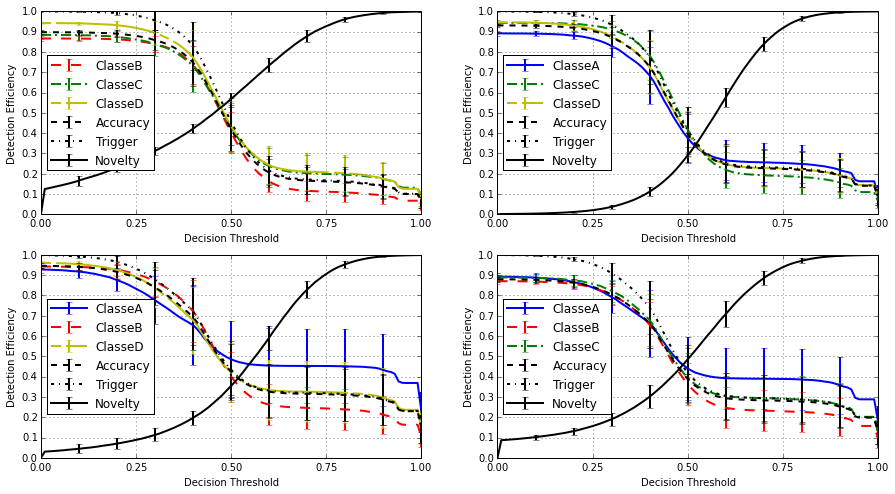

In [48]:
plt.figure(figsize=(15,8), facecolor='w')
thrs = np.arange(0,1.01,0.01)
det_target = 0.9
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    itst = cvPar[novcls]['Indexes'][icv]['IVal']
    T = target[novcls][itst]
    # PLot Known classes
    effnov = np.zeros((NCV, len(thrs)))*np.nan  # novely efficiency
    for iout in range(T.shape[1]):
        # Loop over cross-validation
        tpr = np.zeros((NCV, len(thrs))) * np.nan # true positive rate
        for icv in range(NCV):
            Yout = art_norm[novcls][icv][itst]
            # Loop over thresholds
            for ithr, thr in enumerate(thrs):
                # True Positive: greater than the threshold and the other neurons.
                TP = np.sum((Yout[:, iout]>=thr) & (np.argmax(Yout, axis=1) == iout) & (T[:, iout] == 1))
                tpr[icv,ithr] = TP / float(np.sum((T[:, iout] == 1)))
        # Plot
        icls = np.nonzero(classes == pcdlabels[novcls][iout])[0]
        plt.errorbar(thrs, np.nanmean(tpr, axis=0), np.nanstd(tpr, axis=0), dashes=dashes[icls],color=colors[icls],
                     errorevery=10, label=pcdlabels[novcls][iout])
    
    # Plot total accuracy (efficiency of known-classes)
    efftot = np.zeros((NCV, len(thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = art_norm[novcls][icv][itst]
        # Loop over thresholds
        for ithr, thr in enumerate(thrs):
            # True Positive: greater than the threshold and correct neuron.
            TP = np.sum(((np.max(Yout, axis=1) >= thr) & (np.argmax(Yout, axis=1) == np.argmax(T, axis=1))))
            efftot[icv,ithr] = TP / float(Yout.shape[0])
    plt.errorbar(thrs, np.mean(efftot, axis=0), np.std(efftot, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')

    # System trigger (detection rate)
    efftrg = np.zeros((NCV, len(thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = art_norm[novcls][icv][itst]
        # Loop over thresholds
        for ithr, thr in enumerate(thrs):
            # Just need an output greater than the thrshold
            TP = np.sum((np.max(Yout, axis=1)>=thr))
            efftrg[icv,ithr] = TP / float(Yout.shape[0])
    plt.errorbar(thrs, np.mean(efftrg, axis=0), np.std(efftrg, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    
    # Plot Novelty
    for icv in range(NCV):
        Ynov = art_norm_nov[novcls][icv]
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in thrs], 'f')/Ynov.shape[0]
    plt.errorbar(thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                 fmt='k-', errorevery=10, label='Novelty')
    # PRINT INFO
    idx = np.nonzero(np.mean(efftrg, axis=0) >= det_target)[0][-1]
    print novcls, '\tTrigger: %.2f +- %.2f, Novelty: %.2f +- %.2f, at thrs: %.3f'%(np.mean(efftrg, axis=0)[idx]*100,
                                                                                   np.std (efftrg, axis=0)[idx]*100,
                                                                                   np.mean(effnov, axis=0)[idx]*100,
                                                                                   np.std (effnov, axis=0)[idx]*100,
                                                                                   thrs[idx]),
    print ' accuracy: %.3f +- %.3f'%(np.mean(efftot, axis=0)[idx]*100, np.std(efftot, axis=0)[idx]*100)
    
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(0,1.25,0.25))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.legend(loc='center left').get_frame().set_facecolor('1')

# Analysis

## MLP Output (max) and ART Distance (min)

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


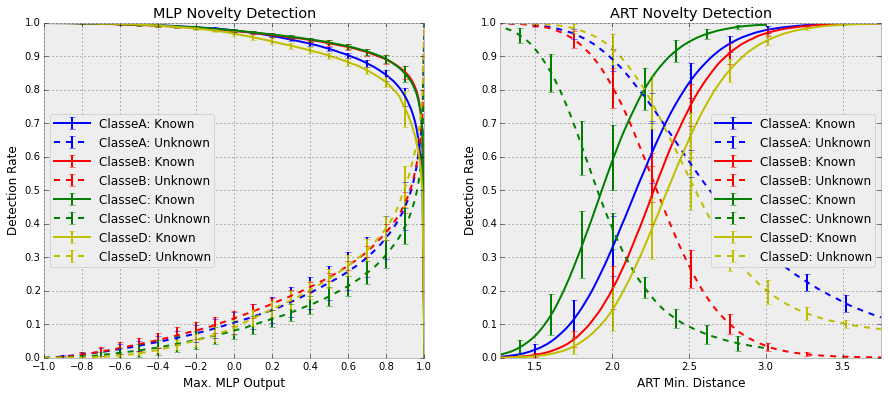

In [8]:
# Loop over novelty classes
plt.figure(figsize=(15,6), facecolor='w')
mlp_thrs = np.arange(-1,1.01,0.01)
art_thrs = np.linspace(0.5, 1.5, 100)
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    probdist = np.zeros((NCV, len(mlp_thrs)))
    probnov = np.zeros((NCV, len(mlp_thrs)))
    artdist = np.zeros((NCV, len(art_thrs)))
    artnov = np.zeros((NCV, len(art_thrs)))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Y = np.max(Y, axis=1)
        probdist[icv] = [(Y >= th).sum() / float(Y.shape[0]) for th in mlp_thrs]
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls][itst].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].feedforward(Y)[0]
        artdist[icv] = [(Y <= th*R).sum() / float(Y.shape[0]) for th in art_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Y = np.max(Y, axis=1)
        probnov[icv] = [(Y < th).sum() / float(Y.shape[0]) for th in mlp_thrs]
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].feedforward(Y)[0]
        artnov[icv] = [(Y > th*R).sum() / float(Y.shape[0]) for th in art_thrs]        
    plt.subplot(1,2,1)
    # PLot Known classes
    icls = np.nonzero(classes == novcls)[0]
    plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-',
                 color=colors[icls], errorevery=10, label=novcls + ': Known')
    # Plot Novelty
    icls = np.nonzero(classes == novcls)[0]
    plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--',
                 color=colors[icls], errorevery=10, label=novcls + ': Unknown')
    plt.subplot(1,2,2)
    # PLot Known classes
    icls = np.nonzero(classes == novcls)[0]
    plt.errorbar(art_thrs * R, np.mean(artdist, axis=0), np.std(artdist, axis=0), fmt='-',
                 color=colors[icls], errorevery=10, label=novcls + ': Known')
    # Plot Novelty
    icls = np.nonzero(classes == novcls)[0]
    plt.errorbar(art_thrs * R, np.mean(artnov, axis=0), np.std(artnov, axis=0), fmt='--',
                 color=colors[icls], errorevery=10, label=novcls + ': Unknown')
plt.subplot(1,2,1)
plt.title('MLP Novelty Detection')
plt.gca().set_yticks(np.linspace(0,1,11))
plt.gca().set_xticks(np.linspace(-1,1,11))
plt.gca().axis([-1,1,0,1])
plt.xlabel('Max. MLP Output')
plt.ylabel('Detection Rate')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.title('ART Novelty Detection')
plt.gca().set_yticks(np.linspace(0,1,11))
plt.gca().axis([art_thrs[1] * R, art_thrs[-1] * R,0,1])
plt.xlabel('ART Min. Distance')
plt.ylabel('Detection Rate')
plt.legend(loc='best')

## Associative Method: Consulting ART

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


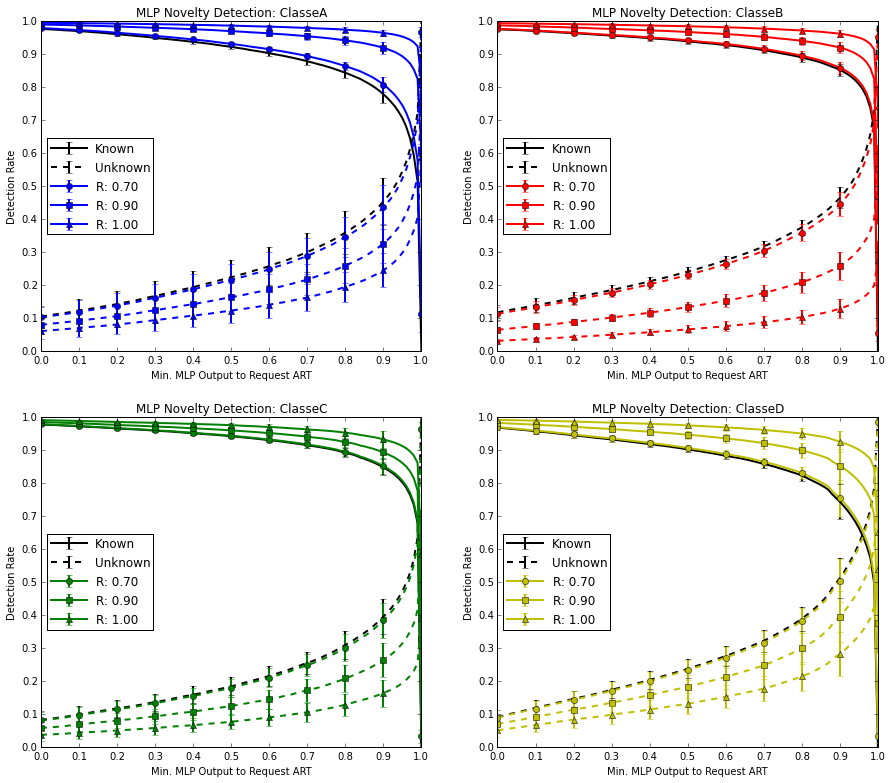

In [49]:
# Loop over novelty classes
plt.figure(figsize=(15,13), facecolor='w')
# Loop over novelties
mlp_thrs = np.arange(0,1.01,0.01)
rad_factor = [0.7, 0.9, 1.0]
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ MLP Alone
    probdist = np.zeros((NCV, len(mlp_thrs)))
    probnov = np.zeros((NCV, len(mlp_thrs)))
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Y = np.max(Y, axis=1)
        probdist[icv] = [(Y >= th).sum() / float(Y.shape[0]) for th in mlp_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Y = np.max(Y, axis=1)
        probnov[icv] = [(Y < th).sum() / float(Y.shape[0]) for th in mlp_thrs]
    # Plot Known classes
    h = plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-k', errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Known')
    # Plot Novelty
    h = plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--k',errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Unknown')
    ############################################################### Associate ART and MLP
    for ir, xr in enumerate(rad_factor):
        probdist = np.zeros((NCV, len(mlp_thrs)))
        probnov = np.zeros((NCV, len(mlp_thrs)))
        # Loop over CV
        for icv in range(NCV):
            # Known-classes
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
            Ymlp = np.max(Y, axis=1)
            Y = pcdnet[novcls][icv].W[0].dot(data[novcls][itst].T).T
            Y = artnet[novcls][icv].trn_data_norm.transform(Y)
            R = artnet[novcls][icv].trn_initial_radius
            Yart = artnet[novcls][icv].feedforward(Y)[0]
            # Loop over threshold
            for i, th in enumerate(mlp_thrs):
                mlp_dec = (Ymlp >= th) | ((Ymlp < th) & (Yart <= R*xr))
                probdist[icv, i] = mlp_dec.sum() / float(mlp_dec.shape[0])
            # Novelty
            Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
            Ymlp = np.max(Y, axis=1)
            Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
            Y = artnet[novcls][icv].trn_data_norm.transform(Y)
            R = artnet[novcls][icv].trn_initial_radius
            Yart = artnet[novcls][icv].feedforward(Y)[0]
            # Loop over threshold
            for i, th in enumerate(mlp_thrs):
                mlp_dec = (Ymlp < th) & (Yart > R*xr)
                probnov[icv, i] = mlp_dec.sum() / float(mlp_dec.shape[0])
        # PLot Known classes
        icls = np.nonzero(classes == novcls)[0]
        h = plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-',
                         color=colors[icls], errorevery=10,
                         markevery=10, marker=markers[ir])
        leg_handlers.append(h)
        leg_labels.append('R: %.2f'%xr)
        # Plot Novelty
        icls = np.nonzero(classes == novcls)[0]
        plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--',
                     color=colors[icls], errorevery=10,
                     markevery=10, marker=markers[ir])
    plt.title('MLP Novelty Detection: ' + novcls)
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.linspace(0,1,11))
    plt.gca().axis([0,1,0,1])
    plt.xlabel('Min. MLP Output to Request ART')
    plt.ylabel('Detection Rate')
    plt.legend(leg_handlers, leg_labels, loc='best')
    plt.grid(True)

## Associative Method: consulting the MLP

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


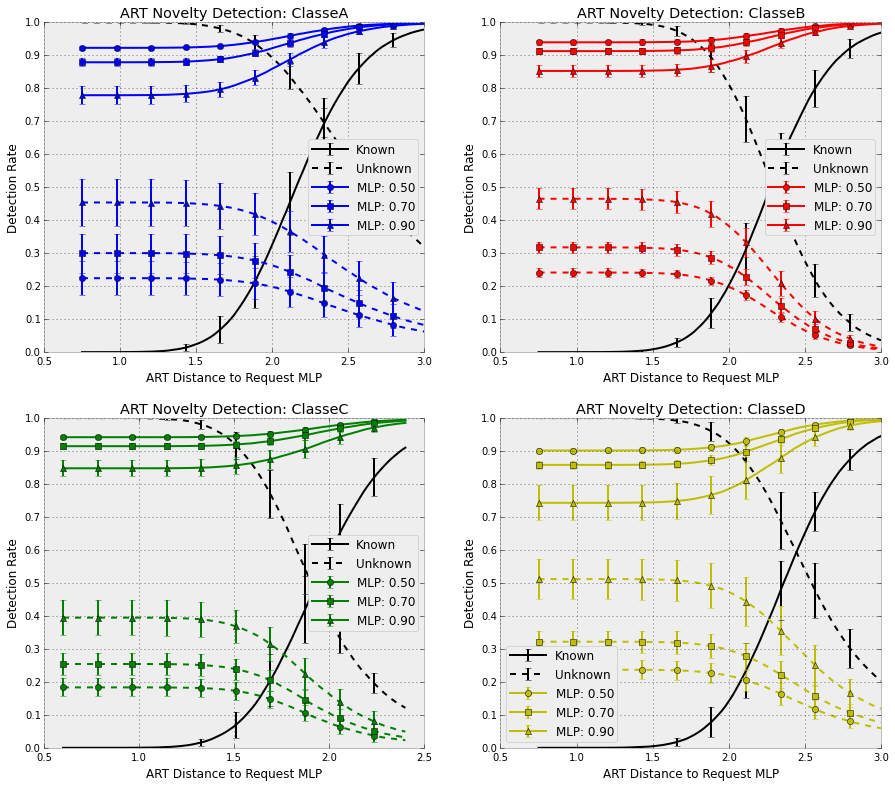

In [6]:
# Loop over novelty classes
plt.figure(figsize=(15,13), facecolor='w')
# Loop over novelties
art_thrs = np.linspace(0.3, 1.2, 100)
mlp_factor = [0.5, 0.7, 0.9]
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ ART Alone
    artdist = np.zeros((NCV, len(art_thrs)))
    artnov = np.zeros((NCV, len(art_thrs)))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls][itst].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].feedforward(Y)[0]
        artdist[icv] = [(Y <= th*R).sum() / float(Y.shape[0]) for th in art_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].feedforward(Y)[0]
        artnov[icv] = [(Y > th*R).sum() / float(Y.shape[0]) for th in art_thrs] 
    # PLot Known classes
    h = plt.errorbar(art_thrs*R, np.mean(artdist, axis=0), np.std(artdist, axis=0), fmt='-k',
                     errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Known')
    # Plot Novelty
    h = plt.errorbar(art_thrs*R, np.mean(artnov, axis=0), np.std(artnov, axis=0), fmt='--k',
                     errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Unknown')
    ############################################################### Associate ART and MLP
    for ir, xr in enumerate(mlp_factor):
        artdist = np.zeros((NCV, len(art_thrs)))
        artnov = np.zeros((NCV, len(art_thrs)))
        # Loop over CV
        for icv in range(NCV):
            # Known-classes
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
            Ymlp = np.max(Y, axis=1)
            Y = pcdnet[novcls][icv].W[0].dot(data[novcls][itst].T).T
            Y = artnet[novcls][icv].trn_data_norm.transform(Y)
            R = artnet[novcls][icv].trn_initial_radius
            Yart = artnet[novcls][icv].feedforward(Y)[0]
            # Loop over threshold
            for i, th in enumerate(R*art_thrs):
                art_dec = (Yart <= th) | ((Yart > th) & (Ymlp > xr))
                artdist[icv, i] = art_dec.sum() / float(art_dec.shape[0])
            # Novelty
            Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
            Ymlp = np.max(Y, axis=1)
            Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
            Y = artnet[novcls][icv].trn_data_norm.transform(Y)
            R = artnet[novcls][icv].trn_initial_radius
            Yart = artnet[novcls][icv].feedforward(Y)[0]
            # Loop over threshold
            for i, th in enumerate(R*art_thrs):
                art_dec = (Yart > th) & (Ymlp < xr)
                artnov[icv, i] = art_dec.sum() / float(art_dec.shape[0])
        # PLot Known classes
        icls = np.nonzero(classes == novcls)[0]
        h = plt.errorbar(art_thrs*R, np.mean(artdist, axis=0), np.std(artdist, axis=0), fmt='-',
                         color=colors[icls], errorevery=10,
                         markevery=10, marker=markers[ir])
        leg_handlers.append(h)
        leg_labels.append('MLP: %.2f'%xr)
        # Plot Novelty
        icls = np.nonzero(classes == novcls)[0]
        plt.errorbar(art_thrs*R, np.mean(artnov, axis=0), np.std(artnov, axis=0), fmt='--',
                     color=colors[icls], errorevery=10,
                     markevery=10, marker=markers[ir])
    plt.title('ART Novelty Detection: ' + novcls)
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.ylim([0,1])
    plt.xlabel('ART Distance to Request MLP')
    plt.ylabel('Detection Rate')
    plt.legend(leg_handlers, leg_labels, loc='best')


## Ensemble Method: weighting MLP and ART

### Normalize ART Response

In [76]:
art_thrs = np.arange(0,1.01,0.01)
art_norm = {}
art_norm_nov = {}
art_error = {}
nsamples = 1000
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    art_norm[novcls] = np.zeros((NCV, target[novcls].shape[0]))
    art_norm_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0]))
    art_error[novcls] = np.zeros((NCV, art_thrs.shape[0]))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itrn = cvPar[novcls]['Indexes'][icv]['ITrn']
        T = target[novcls][itrn]
        X = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        X = artnet[novcls][icv].trn_data_norm.transform(X)
        # Get Data from Each Known-class
        #dmax = 0
        #for iout in range(T.shape[1]):
        #    C = X[itrn][T[:,iout] == 1]
        #    # Calculate distance as in the ART Training
        #    art = artnet[novcls][0]
        #    idx = np.arange(C.shape[0])
        #    np.random.shuffle(idx)
        #    idx = idx[:nsamples]
        #    D = art._distances(C[idx], C[idx])
        #    D = D[np.triu_indices_from(D, 1)] # get triangular without diagonal
        #    D = D.std()*3
        #    dmax = D if dmax < D else dmax
        # Normalize output
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        T = target[novcls][itst]
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        dmax = 1.5*R
        Y[Y > dmax] = dmax
        Ymin = np.min(Y, axis=1) # Get closet class
        # reflect the output: closest to 0 is bad, close to 1 is good
        Ymin = 1 - (Ymin - Ymin.min()) / (dmax - Ymin.min())
        art_norm[novcls][icv] = Ymin
        # Estimate Error
        Y = Y[itst]
        Ymin = Ymin[itst]
        Ymin = Ymin[np.argmin(Y, axis=1) != np.argmax(T, axis=1)]
        art_error[novcls][icv] = np.array([(Ymin >= th).sum() for th in art_thrs]) / float(len(itst))
        ############################################ NOVELTY NORMALIZED OUTPUT
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        dmax = 1.5*R
        Y[Y > dmax] = dmax
        Ymin = np.min(Y, axis=1) # Get closet class
        # reflect the output: closest to 0 is bad, close to 1 is good
        Ymin = 1 - (Ymin - Ymin.min()) / (dmax - Ymin.min())
        art_norm_nov[novcls][icv] = Ymin

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


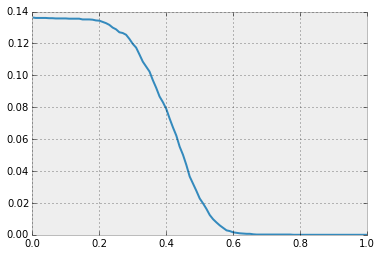

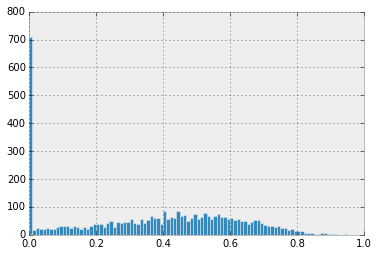

In [78]:
novcls='ClasseA'
plt.plot(art_thrs, art_error[novcls][0])
plt.figure()
plt.hist(art_norm_nov[novcls][icv], 100);

### Estimate MLP Error

In [51]:
mlp_error = {}
mlp_thrs = np.arange(0,1.01,0.01)
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    mlp_error[novcls] = np.zeros((NCV, len(mlp_thrs)))
    T = target[novcls]
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        T = target[novcls][itst]
        # Winner neuron
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Ymax = np.max(Y, axis=1)
        Ymax = Ymax[np.argmax(Y, axis=1) != np.argmax(T, axis=1)]
        mlp_error[novcls][icv] = np.array([(Ymax>=th).sum() for th in mlp_thrs]) / float(len(Y))

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


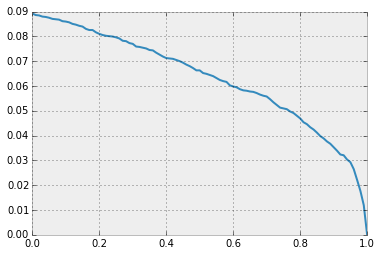

In [10]:
novcls='ClasseA'
plt.plot(mlp_thrs, mlp_error[novcls][0])

### Combine Classifiers

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


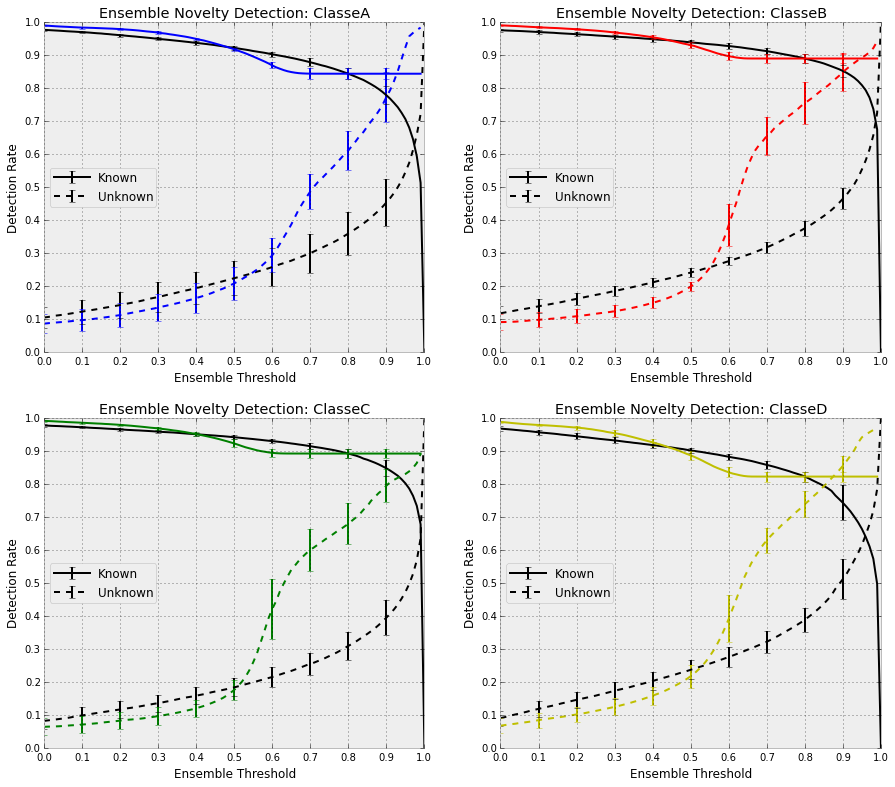

In [90]:
# Loop over novelty classes
plt.figure(figsize=(15,13), facecolor='w')
# Loop over novelties
beta_min = -0.2
beta_max = 0.8
art_factor = 1
ensemble_thrs = np.arange(0.0, 1.0, 0.01)
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ MLP Alone
    probdist = np.zeros((NCV, len(mlp_thrs)))
    probnov = np.zeros((NCV, len(mlp_thrs)))
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Y = np.max(Y, axis=1)
        probdist[icv] = [(Y >= th).sum() / float(Y.shape[0]) for th in mlp_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Y = np.max(Y, axis=1)
        probnov[icv] = [(Y < th).sum() / float(Y.shape[0]) for th in mlp_thrs]
    # Plot Known classes
    h = plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-k', errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Known')
    # Plot Novelty
    h = plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--k',errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Unknown')
    ############################################################ Ensemble
    probdist = np.zeros((NCV, len(ensemble_thrs)))
    probnov = np.zeros((NCV, len(ensemble_thrs)))
    # Loop over CV
    for icv in range(NCV):
        ############################################################# Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Ymlp = np.max(Y, axis=1)
        Yart = art_norm[novcls][icv][itst]
        # Output Weights - MLP
        thrstep = mlp_thrs[1] - mlp_thrs[0]
        Wmlp = mlp_error[novcls][icv][np.array(np.floor(Ymlp / thrstep), 'i')]
        Wmlp[Wmlp == 0] = 1.0
        Wmlp = 1./Wmlp
        # Output Weights - ART
        thrstep = art_thrs[1] - art_thrs[0]
        Wart = art_error[novcls][icv][np.array(np.floor(Yart / thrstep), 'i')]
        Wart[Wart == 0] = 1.0
        Wart = 1./Wart
        # Ensemple output: weighted average
        Yens = (Wmlp*Ymlp + Wart*(Yart)*art_factor) / (Wart*art_factor+Wmlp)
        probdist[icv] = [((Yens >= th)  | (Ymlp >= beta_max)).sum() / float(Yens.shape[0]) for th in ensemble_thrs]
        ############################################################# Novelty
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Ymlp = np.max(Y, axis=1)
        Yart = art_norm_nov[novcls][icv]
        # Output Weights - MLP
        thrstep = mlp_thrs[1] - mlp_thrs[0]
        Wmlp = mlp_error[novcls][icv][np.array(np.floor(Ymlp / thrstep), 'i')]
        Wmlp[Wmlp == 0] = 1.0
        Wmlp = 1./Wmlp
        # Output Weights - ART
        thrstep = art_thrs[1] - art_thrs[0]
        Wart = art_error[novcls][icv][np.array(np.floor(Yart / thrstep), 'i')]
        Wart[Wart == 0] = 1.0
        Wart = 1./Wart
        # Ensemple output: weighted average
        Yens = (Wmlp*Ymlp + Wart*(Yart)*art_factor) / (Wart*art_factor+Wmlp)
        probnov[icv] = [((Yens < th) | (Ymlp < beta_min)).sum() / float(Yens.shape[0]) for th in ensemble_thrs]
    # Plot Ensemble response
    # Known classes
    icls = np.nonzero(classes == novcls)[0]
    h = plt.errorbar(ensemble_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-',
                     color=colors[icls], errorevery=10,
                     markevery=10)
    # Known classes
    icls = np.nonzero(classes == novcls)[0]
    h = plt.errorbar(ensemble_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--',
                     color=colors[icls], errorevery=10,
                     markevery=10)
    plt.title('Ensemble Novelty Detection: ' + novcls)
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.linspace(0,1,11))
    plt.gca().axis([0,1,0,1])
    plt.xlabel('Ensemble Threshold')
    plt.ylabel('Detection Rate')
    plt.legend(leg_handlers, leg_labels, loc='best')

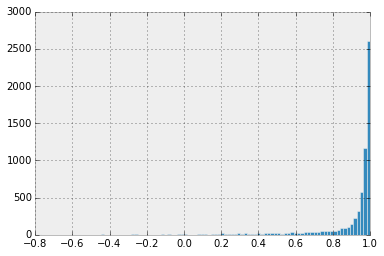

In [33]:
plt.hist(Yens, 100);

In [13]:
x = np.array([0, 0.1, 0.2,0.3])
a = np.array([0.176, 0.2434])
idx = np.array(np.floor(a / 0.1), 'i')
print a
print x[idx]


[ 0.176   0.2434]
[ 0.1  0.2]


Novelty:  ClasseA


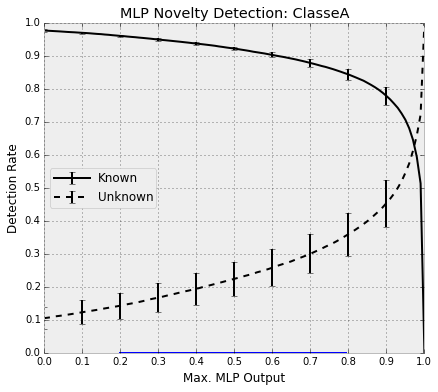

In [103]:
# Loop over novelty classes
plt.figure(figsize=(15,13), facecolor='w')
# Loop over novelties
beta_min = 0.2
beta_max = 0.8
alpha_steep = 1.0
alpha_mean = 0.0
ensemble_thrs = np.arange(0.0, 1.0, 0.01)
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ MLP Alone
    probdist = np.zeros((NCV, len(mlp_thrs)))
    probnov = np.zeros((NCV, len(mlp_thrs)))
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Y = np.max(Y, axis=1)
        probdist[icv] = [(Y >= th).sum() / float(Y.shape[0]) for th in mlp_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Y = np.max(Y, axis=1)
        probnov[icv] = [(Y < th).sum() / float(Y.shape[0]) for th in mlp_thrs]
    # Plot Known classes
    h = plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-k', errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Known')
    # Plot Novelty
    h = plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='--k',errorevery=10)
    leg_handlers.append(h)
    leg_labels.append('Unknown')
    ############################################################### Combine ART and MLP
    probdist = np.zeros((NCV, len(ensemble_thrs)))
    probnov = np.zeros((NCV, len(ensemble_thrs)))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = pcdnet[novcls][icv].feedforward(data[novcls][itst])
        Ymlp = np.max(Y, axis=1)
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls][itst].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Yart = R - artnet[novcls][icv].feedforward(Y)[0]
        ###################################################### Combine outputs
        # Renormalize events in the MLP confusion area
        pd  = (Ymlp >= beta_max).sum()
        idx = (Ymlp >= beta_min) & (Ymlp < beta_max)
        Ymlp = (Ymlp[idx] - beta_min) / (beta_max - beta_min) * 12 - 6
        Ymlp = 1.0 / (1 + np.exp(-alpha_steep * (Ymlp - alpha_mean)))
        # Normalize ART events to range from 0 to 1
        art_min = Yart.min()
        art_max = Yart.max()
        
        Xart = Yart[idx]
        
        Yart = (1-(Yart[idx] - art_min) / (art_max - art_min)) * 12 - 6
        Yart = 1.0 / (1 + np.exp(-Yart))
        
        
        
        
        continue
        
        
        
        
        a = 0.7
        b = 0.3
        
        Y = (b*Yart + a*Ymlp)
        # Loop over threshold
        probdist[icv] = [((Y > th).sum() + pd) / float(len(itst)) for th in ensemble_thrs]
        # Novelty
        Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        Ymlp = np.max(Y, axis=1)
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        R = artnet[novcls][icv].trn_initial_radius
        Yart = R - artnet[novcls][icv].feedforward(Y)[0]
        ###################################################### Combine outputs
        # Renormalize events in the MLP confusion area
        pd  = (Ymlp < beta_min).sum()
        idx = (Ymlp >= beta_min) & (Ymlp < beta_max)
        Ymlp = (Ymlp[idx] - beta_min) / (beta_max - beta_min) * 12 - 6
        Ymlp = 1.0 / (1 + np.exp(-alpha_steep * (Ymlp - alpha_mean)))
        # Normalize ART events to range from 0 to 1
        art_min = Yart.min()
        art_max = Yart.max()
        Yart = (1-(Yart[idx] - art_min) / (art_max - art_min)) * 12 - 6
        Yart = 1.0 / (1 + np.exp(-Yart))
        Y = (b*Yart + a*Ymlp)
        # Loop over threshold
        probnov[icv] = [((Y < th).sum() + pd) / float(data_nov[novcls].shape[0]) for th in ensemble_thrs]
        
        
    # PLot Known classes
    icls = np.nonzero(classes == novcls)[0]
    h = plt.errorbar((ensemble_thrs) * (beta_max - beta_min) + beta_min,
                     np.mean(probdist, axis=0),
                     np.std(probdist, axis=0), fmt='-',
                     color=colors[icls], errorevery=10,
                     markevery=10)
    
    # Plot Novelty
    icls = np.nonzero(classes == novcls)[0]
    plt.errorbar((ensemble_thrs) * (beta_max - beta_min) + beta_min,
                 np.mean(probnov, axis=0),
                 np.std(probnov, axis=0), fmt='--',
                 color=colors[icls], errorevery=10,
                 markevery=10)
    plt.title('MLP Novelty Detection: ' + novcls)
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.linspace(0,1,11))
    plt.gca().axis([0,1,0,1])
    plt.xlabel('Max. MLP Output')
    plt.ylabel('Detection Rate')
    plt.legend(leg_handlers, leg_labels, loc='best')
    break

In [22]:
help(plt.ylim)

Help on function ylim in module matplotlib.pyplot:

ylim(*args, **kwargs)
    Get or set the *y*-limits of the current axes.
    
    ::
    
      ymin, ymax = ylim()   # return the current ylim
      ylim( (ymin, ymax) )  # set the ylim to ymin, ymax
      ylim( ymin, ymax )    # set the ylim to ymin, ymax
    
    If you do not specify args, you can pass the *ymin* and *ymax* as
    kwargs, e.g.::
    
      ylim(ymax=3) # adjust the max leaving min unchanged
      ylim(ymin=1) # adjust the min leaving max unchanged
    
    Setting limits turns autoscaling off for the y-axis.
    
    The new axis limits are returned as a length 2 tuple.



In [2]:
# Load and divide data
globaldata = joblib.load(fname)
cls_data = {}
for cls in classes:
    cls_data[cls] = np.concatenate([y['Signal'][:nPts] for y in globaldata[cls].values()], axis=1).transpose()
def novelty_data(clsnov, data):
    use_classes = np.sort(np.setdiff1d(data.keys(), clsnov))
    Xnov = np.concatenate([data[cls] for cls in clsnov], axis=0)
    X = np.concatenate([data[cls] for cls in use_classes], axis=0)
    nClass = len(use_classes)
    T = None
    for icls, cls in enumerate(use_classes):
        tot = data[cls].shape[0]
        if nClass == 2:
            aux = -np.ones(1)
            aux[0] = 1 if icls > 0 else -1
        else:
            aux = -np.ones(nClass)
            aux[icls] = 1
        T = np.tile(aux,(tot,1)) if T is None else np.concatenate((T, np.tile(aux,(tot,1))))
    return X, T, Xnov

## PCD Network

In [3]:
nov_pcdnet = {}
npcd = 18
IPCD = {
    'ClasseA': 2,
    'ClasseB': 4,
    'ClasseC': 0,
    'ClasseD': 2
}
for cls in noveltyclasses:
    filepcd = pcddir + '/pcdcons_cv_' + cls + '_fromMat_1024nfft.jbl'
    PCD = joblib.load(filepcd)
    nov_pcdnet[cls] = {}
    NCV = PCD['cvPar']['CVNSel']
    nov_pcdnet[cls]['Net'] = [PCD['PCDModel'].results[icv].PCDNets[npcd-1] for icv in range(NCV)]
    nov_pcdnet[cls]['Classes'] = PCD['Classes']
del PCD
del filepcd

## ART Classifier

In [4]:
nov_art = {}
artdir = sonarhome + '/results/classification/novelty/PCD%02i_ARTConstructive/'%npcd
for cls in noveltyclasses:
    fileart = artdir + '/art_pcdcons%i_cv_'%npcd + cls + '_fromMat_1024nfft.jbl'
    nov_art[cls] = joblib.load(fileart)
del fileart

## Performance Over Initial Radius

Novelty:  ClasseA
  CV\R:	2.500, 2.667, 2.833, 3.000, 3.167, 3.333, 3.500, 3.667, 3.833, 4.000
   0 	0.815, 0.878, 0.917, 0.945, 0.963, 0.977, 0.985, 0.990, 0.992, 0.996
   1 	0.819, 0.879, 0.921, 0.951, 0.969, 0.979, 0.986, 0.991, 0.993, 0.995
   2 	0.894, 0.929, 0.956, 0.970, 0.982, 0.988, 0.992, 0.995, 0.996, 0.998
   3 	0.909, 0.944, 0.963, 0.977, 0.985, 0.989, 0.992, 0.996, 0.996, 0.997
   4 	0.807, 0.868, 0.914, 0.945, 0.962, 0.973, 0.985, 0.989, 0.993, 0.994
   5 	0.830, 0.894, 0.925, 0.953, 0.970, 0.980, 0.987, 0.992, 0.994, 0.997
   6 	0.809, 0.872, 0.911, 0.942, 0.961, 0.975, 0.981, 0.990, 0.993, 0.996
   7 	0.861, 0.907, 0.939, 0.962, 0.975, 0.982, 0.988, 0.992, 0.994, 0.996
   8 	0.727, 0.805, 0.870, 0.907, 0.940, 0.960, 0.971, 0.981, 0.987, 0.991
   9 	0.739, 0.819, 0.876, 0.913, 0.944, 0.959, 0.973, 0.981, 0.987, 0.992
Novelty:  ClasseB
  CV\R:	2.500, 2.556, 2.611, 2.667, 2.722, 2.778, 2.833, 2.889, 2.944, 3.000
   0 	0.659, 0.700, 0.732, 0.755, 0.791, 0.813, 0.828, 0.851

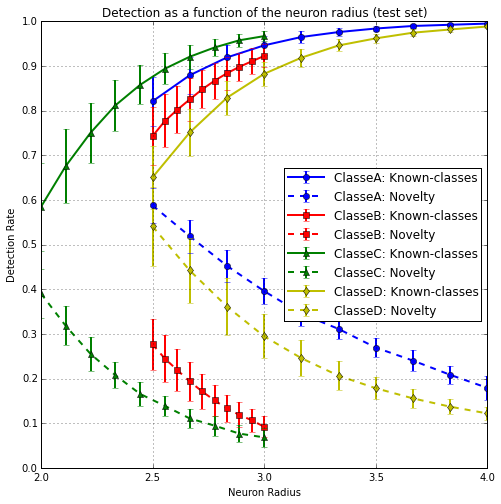

In [5]:
plt.figure(figsize=(8,8), facecolor='w')
for inov, novcls in enumerate(noveltyclasses):
    nGridPar = len(nov_art[novcls]['ARTModel'].results[0][0])
    NCV      = nov_art[novcls]['cvPar']['CVNSel']
    tpr = np.zeros((NCV, nGridPar))
    fpr = np.zeros((NCV, nGridPar))
    sps = np.zeros((NCV, nGridPar))
    # Known-classes and novelty
    Xpar = np.array(nov_art[novcls]['ARTModel'].results[0][1]['Performance'].keys())
    idx = np.argsort(Xpar)
    Xpar = Xpar[idx]
    print 'Novelty: ', novcls
    print '  CV\R:\t', ', '.join(['%.3f'%x for x in Xpar]) 
    for icv in range(NCV):
        tpr[icv] = np.array(nov_art[novcls]['ARTModel'].results[icv][1]['Performance'].values())[idx]
        fpr[icv] = np.array(nov_art[novcls]['ARTModel'].results[icv][1]['NoveltyPerf'].values())[idx]
        sps[icv] = np.sqrt(np.sqrt(tpr[icv] * fpr[icv]) * ((tpr[icv] + fpr[icv])/2.0))
        print '  ',icv, '\t', ', '.join(['%.3f'%x for x in tpr[icv]])
    # PLOT
    icls = np.nonzero(classes == novcls)[0][0]
    plt.errorbar(Xpar, np.mean(tpr,axis=0), np.std(tpr,axis=0),
                 color=colors[icls], fmt='-', marker=markers[icls],
                 label=novcls+': Known-classes')
    plt.errorbar(Xpar, np.mean(fpr,axis=0), np.std(fpr,axis=0),
                 color=colors[icls], fmt='--', marker=markers[icls],
                 label=novcls+': Novelty')
    # Plot labels
    plt.grid(True)
    plt.xlabel('Neuron Radius')
    plt.ylabel('Detection Rate')
    plt.title('Detection as a function of the neuron radius (test set)')
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.ylim([0, 1])
plt.legend(loc='best').get_frame().set_facecolor('w')

## Simulation

In [6]:
from sklearn.externals import joblib
fsimul = sonarhome + '/data/art_pcdcons%i_simul.jbl'%npcd
#fsimul = None
Y = {}
data = {}
if fsimul is not None:
    simul = joblib.load(fsimul)
    Y = simul['Y']
    data = simul['Data']
else:
    for novcls in noveltyclasses:
        print 'Novelty: ', novcls, ', CVs ',
        Y[novcls] = {}
        data[novcls] = {}
        NCV = nov_art[novcls]['cvPar']['CVNSel']
        data[novcls]['Labels'] = nov_pcdnet[novcls]['Classes']
        # Get PCD
        X, T, Xnov = novelty_data([novcls], cls_data)
        data[novcls]['Target'] = T
        # SImulate
        for icv in range(NCV):
            print icv,' ',
            sys.stdout.flush()
            Y[novcls][icv] = {}
            data[novcls][icv] = {}
            # Input
            nnet = nov_pcdnet[novcls]['Net'][icv]
            data[novcls][icv]['Input'] = nnet.W[0].dot(X.transpose()).transpose()
            data[novcls][icv]['InNov'] = nnet.W[0].dot(Xnov.transpose()).transpose()
            idx = np.array([False] * T.shape[0])
            idx[nnet.trn_info.itst] = True
            data[novcls][icv]['ITest'] = idx
            # Output per class
            Y[novcls][icv]['NetOut'] = nnet.feedforward(X)
            Y[novcls][icv]['NetNov'] = nnet.feedforward(Xnov)
            # For each radius
            Y[novcls][icv]['ARTDet'] = {}
            Y[novcls][icv]['ARTOut'] = {}
            Y[novcls][icv]['ARTNov'] = {}
            for rad in nov_art[novcls]['ARTModel'].results[icv][0].keys():
                artnet = nov_art[novcls]['ARTModel'].results[icv][0][rad]
                Xart = artnet.trn_data_norm.transform(data[novcls][icv]['Input'])
                artout = artnet.classify(Xart)
                Y[novcls][icv]['ARTOut'][rad] = artout[0]
                Y[novcls][icv]['ARTDet'][rad] = artout[1]
                XartNov = artnet.trn_data_norm.transform(data[novcls][icv]['InNov'])
                Y[novcls][icv]['ARTNov'][rad] = artnet.classify(XartNov)
        print '. Done.'
    fsimul = sonarhome + '/data/art_pcdcons%i_simul.jbl'%npcd
    simul = {'Y': Y, 'Data': data}
    joblib.dump(simul, fsimul, compress=9)

## ART Radius

### ART + NNet

In [7]:
def plot_art_net_dist(novcls, net_out, art_out, net_thr, art_thr):
    plt.figure(figsize = (12,5), facecolor='w')
    plt.subplot(1,2,1)    
    plt.plot(net_out, art_out, 'ok')
    ax = plt.axis()
    plt.plot([net_thr, net_thr], ax[2:], '--r') # Net threshold
    plt.plot(ax[:2], [art_thr, art_thr], '--r') # ART threshold
    plt.xlabel('Neural Network Output')
    plt.ylabel('ART Distance')
    plt.grid(True)
    plt.subplot(1,2,2)
    #h2 = plt.hist2d(net_out,art_out, [20,10], cmap = plt.cm.Greys);
    h2 = np.histogram2d(art_out, net_out, [20,20])
    ms = plt.matshow(np.flipud(np.abs(h2[0])), cmap=plt.cm.Greys, fignum=0, extent=[0,1,0,1],
                     norm=mpl.colors.LogNorm())
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.plot([(net_thr+1)/2, (net_thr+1)/2], [0,1], '--r') # Net threshold
    plt.plot([0,1], [(art_thr-ax[2])/(ax[3]-ax[2]), (art_thr-ax[2])/(ax[3]-ax[2])], '--r') # ART threshold
    plt.gca().autoscale(False)
    plt.gca().set_xticks(np.linspace(0,1,len(h2[2]+1)))
    plt.gca().set_xticklabels(['%.2f'%x for x in np.linspace(-1, 1,len(h2[2]+1))])
    plt.gca().set_yticks(np.linspace(0,1,len(h2[1]+1)))
    plt.gca().set_yticklabels(['%.2f'%x for x in np.linspace(ax[2], ax[3],len(h2[1]+1))])
    plt.xticks(rotation='90')
    plt.xlabel('Neural Network Output')
    plt.ylabel('ART Distance')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(ms, cax=cax)


In [8]:
novcls = 'ClasseA'
icv = IPCD[novcls]
min_det = 0.9
itst = data[novcls][icv]['ITest']
# Find radius for 90% at known-classes
eff_rad = np.array([[rad, (Y[novcls][icv]['ARTDet'][rad][itst] != -1).sum()/float(itst.sum())]
                    for rad in np.sort(Y[novcls][icv]['ARTDet'].keys())])
rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
net_thr = 0.75
art_out = rad - Y[novcls][icv]['ARTOut'][rad][itst]
net_out = np.max(Y[novcls][icv]['NetOut'][itst,:], axis=1)
art_nov = rad - Y[novcls][icv]['ARTNov'][rad][0]
net_nov = np.max(Y[novcls][icv]['NetNov'], axis=1)

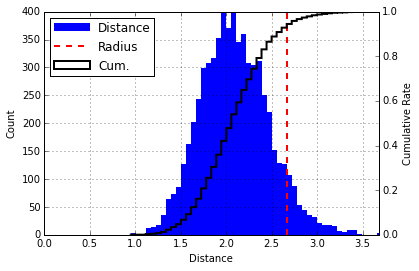

In [9]:
# ART Radius Distribution - Known CLasses
h0 = plt.hist(art_out, 50, edgecolor='none', label='Distance');
h1 = plt.plot([rad, rad],[0, h0[0].max()], '--r', label='Radius')
plt.ylabel('Count')
plt.xlabel('Distance')
plt.grid(True)
ax = plt.gca().twinx()
h2 = ax.hist(art_out, 50, cumulative=True, histtype = 'step', color='k', normed=True, lw=2, label='Cum.');
plt.ylim([0, 1])
plt.xlim([0, art_out.max()*0.99])
plt.ylabel('Cumulative Rate')
plt.legend(handles=[h0[2][0],h1[0],h2[2][0]],loc='upper left').get_frame().set_facecolor('1')

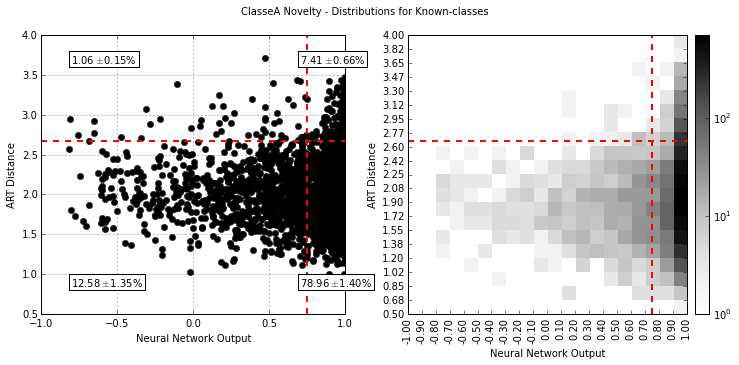

In [10]:
# NNet and ARTNet
plot_art_net_dist(novcls, net_out, art_out, net_thr, rad)
plt.gcf().suptitle(novcls + ' Novelty - Distributions for Known-classes')
# Calculate quarters for known class
CM_avg = np.zeros((2,2))
CM_std = np.zeros((2,2))
effs = np.zeros((4, len(Y[novcls])))
for icv in range(len(Y[novcls])):
    itst = data[novcls][icv]['ITest']
    # Find radius for 90% at known-classes
    eff_rad = np.array([[rad, (Y[novcls][icv]['ARTDet'][rad][itst] != -1).sum()/float(itst.sum())]
                        for rad in np.sort(Y[novcls][icv]['ARTDet'].keys())])
    rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
    i_art = Y[novcls][icv]['ARTOut'][rad][itst] < 0
    i_net = np.max(Y[novcls][icv]['NetOut'][itst,:], axis=1) >= net_thr
    # 1st quarter: > ART, < NN
    effs[0,icv] = float((i_art & ~i_net).sum()) / i_net.shape[0]
    # 2nd quarter: > ART, > NN
    effs[1,icv] = float((i_art & i_net).sum()) / i_net.shape[0]
    # 3rd quarter: < ART, < NN
    effs[2,icv] = float((~i_art & ~i_net).sum()) / i_net.shape[0]
    # 4th quarter: < ART, > NN
    effs[3,icv] = float((~i_art & i_net).sum()) / i_net.shape[0]
plt.subplot(1,2,1)
plt.text(0.10, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[0]), 100*np.std(effs[0])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[1]), 100*np.std(effs[1])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.10, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[2]), 100*np.std(effs[2])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[3]), 100*np.std(effs[3])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))

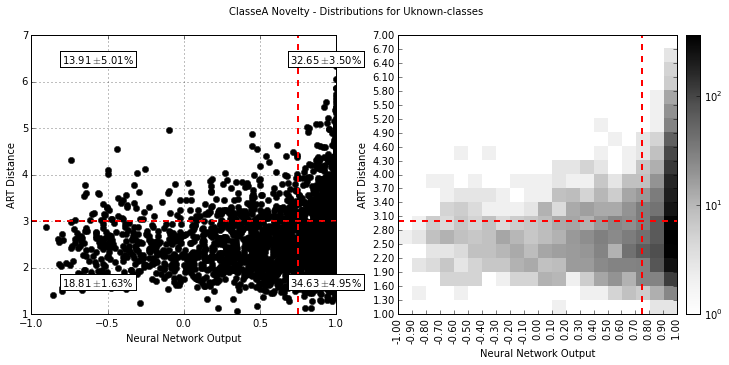

In [11]:
# NNet and ARTNet - NOvelty
plot_art_net_dist(novcls, net_nov, art_nov, net_thr, rad)
plt.gcf().suptitle(novcls + ' Novelty - Distributions for Uknown-classes')
# Calculate quarters for Unknown class
CM_avg = np.zeros((2,2))
CM_std = np.zeros((2,2))
effs = np.zeros((4, len(Y[novcls])))
for icv in range(len(Y[novcls])):
    itst = data[novcls][icv]['ITest']
    # Find radius for 90% at known-classes
    eff_rad = np.array([[rad, (Y[novcls][icv]['ARTDet'][rad][itst] != -1).sum()/float(itst.sum())]
                        for rad in np.sort(Y[novcls][icv]['ARTDet'].keys())])
    rad = eff_rad[ np.nonzero(eff_rad[:,1] >= min_det)[0][0], 0]
    i_art = Y[novcls][icv]['ARTNov'][rad][0] < 0
    i_net = np.max(Y[novcls][icv]['NetNov'], axis=1) > net_thr
    # 1st quarter: > ART, < NN
    effs[0,icv] = float((i_art & ~i_net).sum()) / i_net.shape[0]
    # 2nd quarter: > ART, > NN
    effs[1,icv] = float((i_art & i_net).sum()) / i_net.shape[0]
    # 3rd quarter: < ART, < NN
    effs[2,icv] = float((~i_art & ~i_net).sum()) / i_net.shape[0]
    # 4th quarter: < ART, > NN
    effs[3,icv] = float((~i_art & i_net).sum()) / i_net.shape[0]
plt.subplot(1,2,1)
plt.text(0.10, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[0]), 100*np.std(effs[0])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.9, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[1]), 100*np.std(effs[1])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.10, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[2]), 100*np.std(effs[2])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))
plt.text(0.85, 0.1, r'%.2f$\pm$%.2f%%'%(100*np.mean(effs[3]), 100*np.std(effs[3])),
         transform=plt.gca().transAxes, bbox=dict(facecolor='w'))

In [49]:
def plot_confusion(CM_avg, CM_std, labels, nocolorbar=False):
    labels = np.concatenate(([''], labels))
    ms = plt.matshow(CM_avg, cmap=plt.cm.Blues, vmin=0, vmax=100, fignum=0)
    plt.gca().set_xticklabels(labels, size=14)
    plt.gca().set_yticklabels(labels, size=14)
    for i in range(CM_avg.shape[0]):
        for j in range(CM_avg.shape[1]):
            color = 'k'if CM_avg[i,j] < 70 else 'w'
            if CM_std is not None:
                plt.text(j,i,'%.2f\n$\pm$\n%.2f'%(CM_avg[i,j], CM_std[i,j]), ha='center',
                         va='center',size=14, color=color, weight='bold')
            else:
                plt.text(j,i,'%.2f'%(CM_avg[i,j]), ha='center', va='center',size=14, color=color, weight='bold')
    plt.xlabel('Detection', size=14)
    plt.ylabel('Truth', size=14)
    #title = plt.title(r'Confusion Matrix (%)', va='bottom')
    #title.set_y(1.09) 
    if not nocolorbar:
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", "5%", pad="3%")
        plt.colorbar(ms, cax=cax)
        plt.ylabel('%')
    return ms

## ART + NNet Operation - Confusion Matrix

In [1]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (13, 10), facecolor='w')
min_art_det = 0.9
# Loop over novelties
axes = [None]*4
CM_ART_avg = {}
CM_ART_std = {}
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,2,inov+1)
    NCV = nov_art[novcls]['cvPar']['CVNSel']
    T = np.argmax(data[novcls]['Target'], 1)
    # Loop over cross-validation
    eff = [None]*NCV
    tot_as_nov = np.zeros(NCV)
    tot_known = np.zeros(NCV)    
    for icv in range(NCV):
        itst = data[novcls][icv]['ITest']
        # Find radius for 90% at known-classes
        eff_rad = np.array([[rad, (Y[novcls][icv]['ARTDet'][rad][itst] != -1).sum()/float(itst.sum())]
                            for rad in np.sort(Y[novcls][icv]['ARTDet'].keys())])
        idx = np.nonzero(eff_rad[:,1] >= min_art_det)[0]
        if not len(idx):
            idx = np.nonzero(eff_rad[:,1] <= min_art_det)[0]
            idx = idx[::-1]
        rad = eff_rad[idx[0], 0]
        i_art = Y[novcls][icv]['ARTOut'][rad][itst] < 0 # detected as novelty
        i_nov = Y[novcls][icv]['ARTNov'][rad][1] < 0
        Yout = np.argmax(Y[novcls][icv]['NetOut'][itst], 1)
        Ynov = np.argmax(Y[novcls][icv]['NetNov'], 1)
        # Make Target and output with novelty
        cmT  = np.concatenate((T[itst], np.ones(Ynov.shape[0])*len(noveltyclasses)))
        Yout[i_art] = len(noveltyclasses)
        Ynov[i_nov] = len(noveltyclasses)
        cmY = np.concatenate((Yout, Ynov))
        cm = confusion_matrix(cmT, cmY)
        eff[icv] = (cm.T / np.array(cm.sum(1),'f')).T
        tot_as_nov[icv] = np.sum(cm[:3,3])
        tot_known[icv] = float(itst.sum())
    tot_as_nov = (1-tot_as_nov / tot_known) * 100
    print novcls,'\tAverage known as novelty: %.2f +- %.2f'%(np.mean(tot_as_nov), np.std(tot_as_nov))        
    CM_ART_avg[novcls] = np.array(eff).mean(axis=0) * 100
    CM_ART_std[novcls] = np.array(eff).std(axis=0) * 100
    ms = plot_confusion(CM_ART_avg[novcls], CM_ART_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, axes[3].get_position().y0, 0.05, (axes[0].get_position().y1-
                                                                axes[3].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')

NameError: name 'plt' is not defined

## NNet Operation - Confusion Matrix

ClasseA 	Average known as novelty: 91.32 +- 0.65
ClasseB 	Average known as novelty: 90.23 +- 1.19
ClasseC 	Average known as novelty: 91.27 +- 0.94
ClasseD 	Average known as novelty: 92.09 +- 0.92


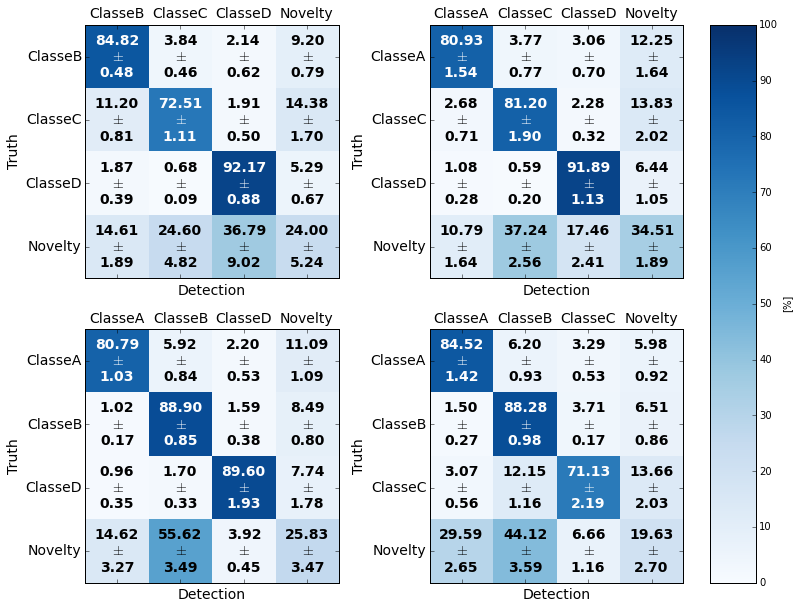

In [54]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (13, 10), facecolor='w')
min_det_thr = { # depends on where the total efficiency crosses 90%
    'ClasseA': 0.55,
    'ClasseB': 0.75,
    'ClasseC': 0.71,
    'ClasseD': 0.38
}
# Loop over novelties
axes = [None] * len(noveltyclasses)
CM_MLP_avg = {}
CM_MLP_std = {}
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,2,inov+1)
    NCV = nov_art[novcls]['cvPar']['CVNSel']
    T = np.argmax(data[novcls]['Target'], 1)
    # Loop over cross-validation
    eff = [None]*NCV
    tot_as_nov = np.zeros(NCV)
    tot_known = np.zeros(NCV)
    for icv in range(NCV):
        itst = data[novcls][icv]['ITest']
        i_art = np.max(Y[novcls][icv]['NetOut'][itst],1) < min_det_thr[novcls] # detected as novelty
        i_nov = np.max(Y[novcls][icv]['NetNov'],1) < min_det_thr[novcls]
        Yout = np.argmax(Y[novcls][icv]['NetOut'][itst], 1)
        Ynov = np.argmax(Y[novcls][icv]['NetNov'], 1)
        # Make Target and output with novelty
        cmT  = np.concatenate((T[itst], np.ones(Ynov.shape[0])*len(noveltyclasses)))
        Yout[i_art] = len(noveltyclasses)
        Ynov[i_nov] = len(noveltyclasses)
        cmY = np.concatenate((Yout, Ynov))
        cm = confusion_matrix(cmT, cmY)
        tot_as_nov[icv] = np.sum(cm[:3,3])
        tot_known[icv] = float(itst.sum())
        eff[icv] = (cm.T / np.array(cm.sum(1),'f')).T
        
    tot_as_nov = (1-tot_as_nov / tot_known) * 100
    print novcls,'\tAverage known as novelty: %.2f +- %.2f'%(np.mean(tot_as_nov), np.std(tot_as_nov))        
    CM_MLP_avg[novcls] = np.array(eff).mean(axis=0) * 100
    CM_MLP_std[novcls] = np.array(eff).std(axis=0) * 100
    ms = plot_confusion(CM_MLP_avg[novcls], CM_MLP_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, axes[3].get_position().y0, 0.05, (axes[0].get_position().y1-
                                                                axes[3].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')

### Confusion Matrixes Combined

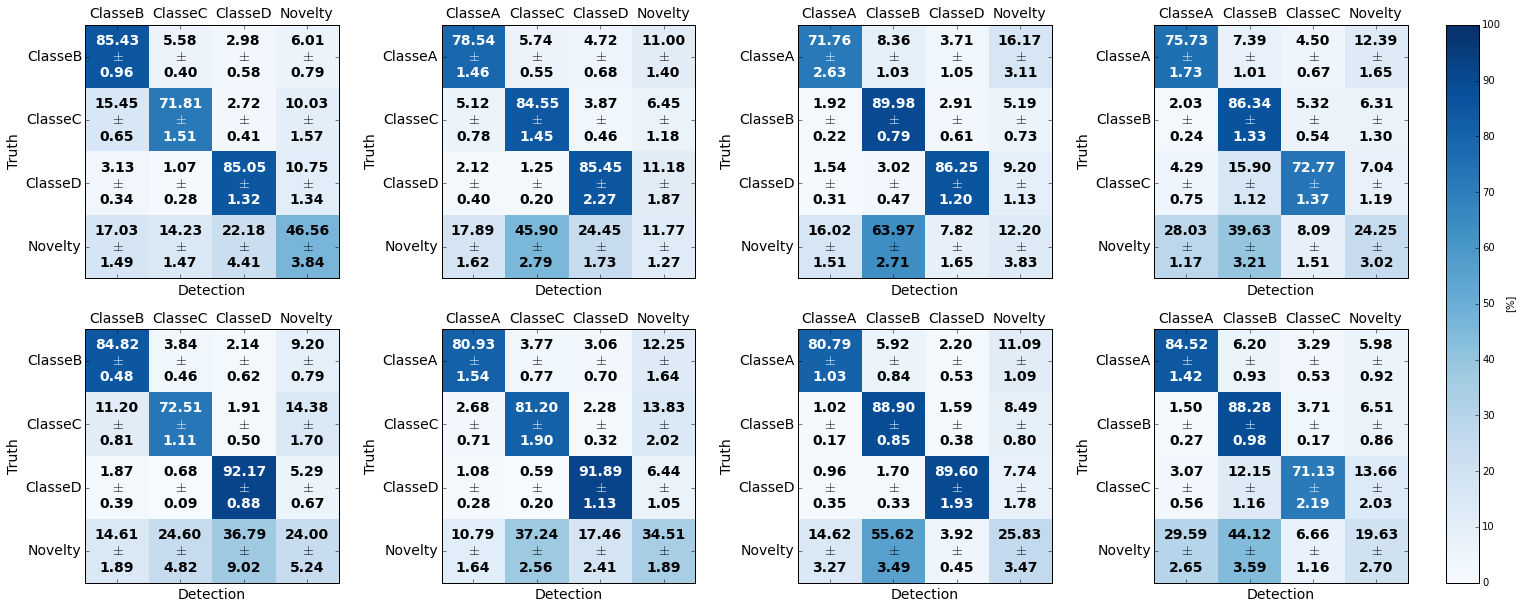

In [50]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize = (23, 10), facecolor='w')
# Loop over novelties
axes = [None]*8
for inov, novcls in enumerate(noveltyclasses):
    axes[inov] = plt.subplot(2,4,inov+1)
    ms = plot_confusion(CM_ART_avg[novcls], CM_ART_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
    axes[inov+4] = plt.subplot(2,4,inov+1+4)
    ms = plot_confusion(CM_MLP_avg[novcls], CM_MLP_std[novcls],
                        np.concatenate((data[novcls]['Labels'], ['Novelty'])), nocolorbar=True)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, axes[7].get_position().y0, 0.02, (axes[0].get_position().y1-
                                                                axes[7].get_position().y0)])
fig.colorbar(ms, cax=cbar_ax)
plt.ylabel('[%]')